In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('..')
from src.data.dataset_generator import DatasetGenerator
%matplotlib inline
sns.set_style('whitegrid')
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')
from src.data.entsoe_data_getter import *
import statsmodels.api as sm
from sklearn import preprocessing
from src.data.weather_data_getter import WeatherDataGetter
from sklearn.preprocessing import MinMaxScaler

### Get the dataset

And set Time as index.

In [2]:
dg = DatasetGenerator(['montel'])
dataset = dg.get_dataset('2016-01-01', '2021-05-31', 'T23')
dataset.set_index('Time', inplace=True)
date_min = dataset.index.min()
date_max = dataset.index.max()
print(dataset.head())
print('Minimum date from data set: {}'.format(date_min))
print('Maximum date from data set: {}'.format(date_max))

                     SPOTPrice
Time                          
2016-01-01 00:00:00      23.86
2016-01-01 01:00:00      22.39
2016-01-01 02:00:00      20.59
2016-01-01 03:00:00      16.81
2016-01-01 04:00:00      17.41
Minimum date from data set: 2016-01-01 00:00:00
Maximum date from data set: 2021-05-31 23:00:00


Since wind turbines are more common in the north of germany, and photovoltaic systems are more common in the south of germany, we are getting weather data from hamburg and munich.s

In [3]:
wg = WeatherDataGetter("weather_test",location= "hamburg, germany", suffix='_ham')
data_weather_hamburg= wg.get_data('2016-01-01', '2021-05-31', overwrite=True)
data_weather_hamburg.set_index('Time', inplace=True)

Data coverage 100%


In [4]:
wg = WeatherDataGetter("weather_test",location= "munich, germany")
data_weather_munich= wg.get_data('2016-01-01', '2021-05-31', overwrite=True)
data_weather_munich.set_index('Time', inplace=True)

Data coverage 100%


Now we are getting the hourly Load and the  Solar and wind electricity generation from Entosoe. 
The EntsoeDataGetter is still not included in master branch so need to be added manually. SOmehow only works for 2021

In [5]:
eg = EntsoeDataGetter()
dataset_entsoe = eg.get_data(start_date='2021-01-01',
                              end_date='2021-05-31', end_time='T23')
dataset_entsoe.set_index('Time', inplace=True)

In [6]:
#dataset_all = pd.concat([dataset['2021-01-01':'2021-05-31'], entsoe_data], axis=1)

In [7]:
dataset_entsoe.head()

,Load,Solar,Wind Offshore,Wind Onshore
Time,,,,
2021-01-01 00:00:00,45094.50,0.0,381.50,3968.00
2021-01-01 01:00:00,43308.50,0.0,392.25,3614.50
2021-01-01 02:00:00,41598.00,0.0,303.75,3270.00
2021-01-01 03:00:00,40745.25,0.0,317.50,2827.75
2021-01-01 04:00:00,40717.00,0.0,292.25,2536.25


### Overview

Get an overview on data over the years. Resample data to monthly mean.

In [8]:
dataset_res_month = dataset.resample('MS').mean()

In [9]:
dataset_res_month.head()

,SPOTPrice
Time,
2016-01-01,29.036371
2016-02-01,21.989555
2016-03-01,24.297245
2016-04-01,24.213486
2016-05-01,22.542366


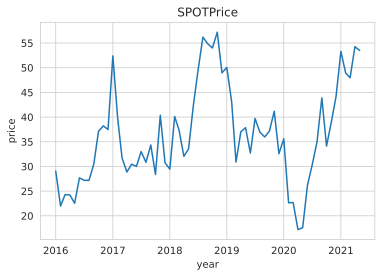

In [10]:
plt.figure()
sns.lineplot(x='Time',y='SPOTPrice',data=dataset_res_month)
plt.title('SPOTPrice',fontsize=12)
plt.xlabel('year',fontsize=10)
plt.ylabel('price',fontsize=10)
plt.show()

Decomposition: Show trend, seasonality and residual of monthly mean spotprice.
The trend shows a clear collapse during 2020 most probably due to the covid pandemic.

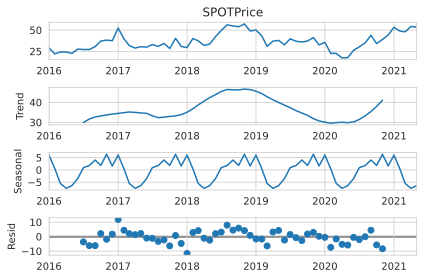

In [11]:
decomposition_add = sm.tsa.seasonal_decompose(dataset_res_month["SPOTPrice"], period=12, model="additive")
# comment: seasonal_decompose expects index to be datetime format
fig = decomposition_add.plot()
plt.show()

Decomposition: Show seasonality and trend during the day in a timeframe of some days.
A strong seasonality is shown during the day, with peaks at around 10-12am and 5-7pm

In [12]:
new_dataset_hourly=dataset["2020-09-01":"2020-09-10"]

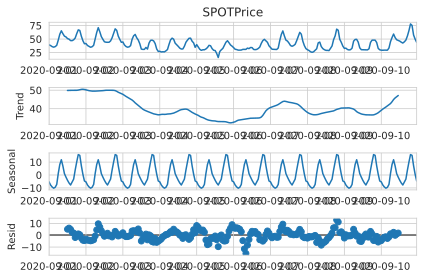

In [13]:
decomposition_add = sm.tsa.seasonal_decompose(new_dataset_hourly["SPOTPrice"], period=24, model="additive")
fig = decomposition_add.plot()
plt.show()

Decomposition: Show the weekly seasonality and trend

In [14]:
dataset_res_day = dataset["2020-08"].resample('D').mean()

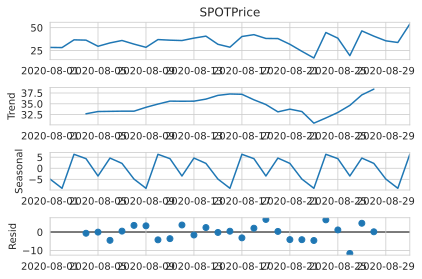

In [15]:
decomposition_add = sm.tsa.seasonal_decompose(dataset_res_day["SPOTPrice"], period=7, model="additive")
fig = decomposition_add.plot()
plt.show()

### Lagplot

Lag plot on hourly data. Shows how the data depends on data on timestep before

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

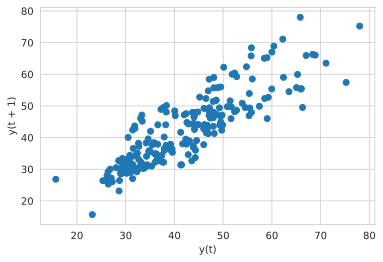

In [16]:
from pandas.plotting import lag_plot

lag_plot(new_dataset_hourly["SPOTPrice"])

### Autocorrelation and partial autocorrelation of Spotprice

AC and PCF for daily mean spot price. Shows a correlation between the current day and the same day one week ago. -> same weekdays have similar spotprices

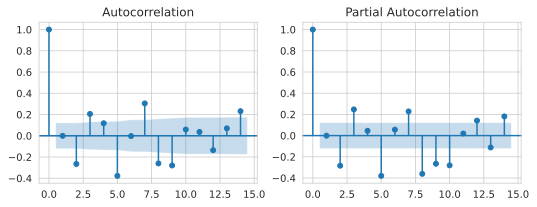

In [17]:
import statsmodels.tsa.api as smt

fig, axes = plt.subplots(1, 2)
fig.set_figwidth(7.5)
fig.set_figheight(3)
smt.graphics.plot_acf(dataset_res_day['SPOTPrice'], lags=14, ax=axes[0], alpha=0.5)
smt.graphics.plot_pacf(dataset_res_day['SPOTPrice'], lags=14, ax=axes[1], alpha=0.5)
plt.tight_layout()

AC and PCF for hourly spot price.

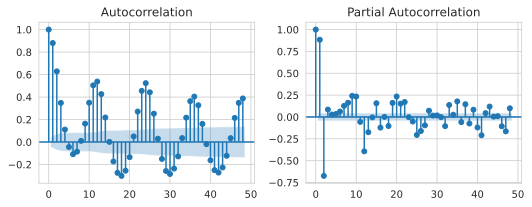

In [18]:
import statsmodels.tsa.api as smt

fig, axes = plt.subplots(1, 2)
fig.set_figwidth(7.5)
fig.set_figheight(3)
smt.graphics.plot_acf(new_dataset_hourly['SPOTPrice'], lags=48, ax=axes[0], alpha=0.5)
smt.graphics.plot_pacf(new_dataset_hourly['SPOTPrice'], lags=48, ax=axes[1], alpha=0.5)
plt.tight_layout()

In order to plot the rest of the data we scale the entsoe data.


In [19]:
scaler = preprocessing.StandardScaler(with_mean=False)
dataset_entsoe[["Load_scaled","Solar_scaled","Wind Offshore_scaled","Wind Onshore_scaled"]] = scaler.fit_transform(dataset_entsoe[["Load","Solar","Wind Offshore","Wind Onshore"]])

And scale the spotprice

In [20]:
scaler = preprocessing.StandardScaler(with_mean=False)
dataset["SPOTPrice_scaled"] = scaler.fit_transform(dataset["SPOTPrice"].values.reshape(-1, 1))

<AxesSubplot:xlabel='Time'>

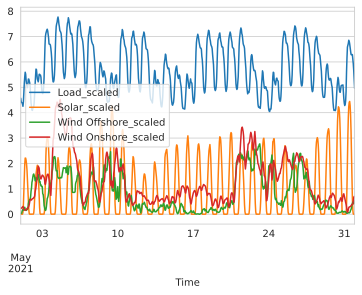

In [21]:
dataset_entsoe.loc["2021-05",["Load_scaled","Solar_scaled","Wind Offshore_scaled","Wind Onshore_scaled"]].plot()

Now we plot the scaled spotpriceand the solar and wind energy generation.
We can see that the price correlates with the overall renewalbe energy generation. The price drops for example when solar and wind energy generation provide a large amount of electricity.

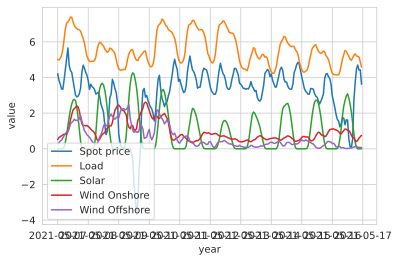

In [22]:
start_day = '2021-05-07' 
end_day = "2021-05-16"
plt.figure()
sns.lineplot(x='Time',y='SPOTPrice_scaled',data=dataset[start_day:end_day], label = "Spot price")
sns.lineplot(x='Time',y='Load_scaled',data=dataset_entsoe[start_day:end_day], label = "Load")
sns.lineplot(x='Time',y='Solar_scaled',data=dataset_entsoe[start_day:end_day], label = "Solar")
sns.lineplot(x='Time',y='Wind Onshore_scaled',data=dataset_entsoe[start_day:end_day], label = "Wind Onshore")
sns.lineplot(x='Time',y='Wind Offshore_scaled',data=dataset_entsoe[start_day:end_day], label = "Wind Offshore")

plt.xlabel('year',fontsize=10)
plt.ylabel('value',fontsize=10)
plt.show()

Scatter plot of spot price and each weather data. 
Not really a correlation between the weather values and the spotprice.

In [23]:
#year = "2021"
#fig, axes = plt.subplots(4,2)
#fig.set_figwidth(8)
#fig.set_figheight(16)
#axes[0,0].scatter(dataset[year][["temp"]],dataset[year][["SPOTPrice"]])
#axes[0,0].set_xlabel('The air temperature in °C')
#axes[0,1].scatter(dataset[year][["dwpt"]],dataset[year][["SPOTPrice"]])
#axes[0,1].set_xlabel('The dew point in °C')
#axes[1,0].scatter(dataset[year][["rhum"]],dataset[year][["SPOTPrice"]])
#axes[1,0].set_xlabel('The relative humidity in percent %')
#axes[1,1].scatter(dataset[year][["prcp"]],dataset[year][["SPOTPrice"]])
#axes[1,1].set_xlabel('The one hour precipitation total in mm')
#axes[2,0].scatter(dataset[year][["wspd"]],dataset[year][["SPOTPrice"]])
#axes[2,0].set_xlabel('The average wind speed in km/h')
#axes[2,1].scatter(dataset[year][["pres"]],dataset[year][["SPOTPrice"]])
#axes[2,1].set_xlabel('The average sea-level air pressure in hPa')
#axes[3,0].scatter(dataset[year][["tsun"]],dataset[year][["SPOTPrice"]])
#axes[3,0].set_xlabel('The one hour sunshine total in minutes (m)')
#plt.tight_layout()

Scatter plot of spot price and each Entsoe data

We add the sum of solar and wind energy generation, and we can determine a correlation between the spotprice and the sum of renewable energy generation.

In [24]:
dataset_entsoe["Sum renewables"] = dataset_entsoe[["Solar","Wind Offshore","Wind Onshore"]].sum(axis=1)

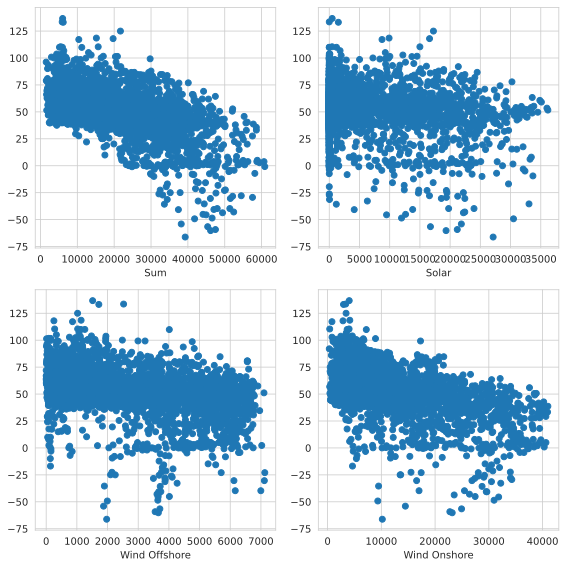

In [25]:
year = "2021"
fig, axes = plt.subplots(2,2)
fig.set_figwidth(8)
fig.set_figheight(8)
axes[0,0].scatter(dataset_entsoe[year][["Sum renewables"]],dataset[year][["SPOTPrice"]])
axes[0,0].set_xlabel('Sum')
axes[0,1].scatter(dataset_entsoe[year][["Solar"]],dataset[year][["SPOTPrice"]])
axes[0,1].set_xlabel('Solar')
axes[1,0].scatter(dataset_entsoe[year][["Wind Offshore"]],dataset[year][["SPOTPrice"]])
axes[1,0].set_xlabel('Wind Offshore')
axes[1,1].scatter(dataset_entsoe[year][["Wind Onshore"]],dataset[year][["SPOTPrice"]])
axes[1,1].set_xlabel('Wind Onshore')

plt.tight_layout()

Since the time of the day is important for the day ahead and week ahead prediction, we are only taking values at that specific time. (i.e. 9:00 am)

In [26]:
time = 15
dataset_time = dataset[dataset.index.hour==time]
dataset_entsoe_time = dataset_entsoe[dataset_entsoe.index.hour==time]

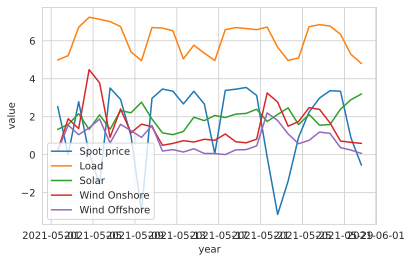

In [27]:

start_day = '2021-05-01' 
end_day = "2021-05-30"
plt.figure()
sns.lineplot(x='Time',y='SPOTPrice_scaled',data=dataset_time[start_day:end_day], label = "Spot price")
sns.lineplot(x='Time',y='Load_scaled',data=dataset_entsoe_time[start_day:end_day], label = "Load")
sns.lineplot(x='Time',y='Solar_scaled',data=dataset_entsoe_time[start_day:end_day], label = "Solar")
sns.lineplot(x='Time',y='Wind Onshore_scaled',data=dataset_entsoe_time[start_day:end_day], label = "Wind Onshore")
sns.lineplot(x='Time',y='Wind Offshore_scaled',data=dataset_entsoe_time[start_day:end_day], label = "Wind Offshore")
#sns.lineplot(x='Time',y='Sum renewables',data=dataset_entsoe_time[start_day:end_day], label = "Sum renewables")
plt.xlabel('year',fontsize=10)
plt.ylabel('value',fontsize=10)
plt.show()

Crosscorrelation between Spot price and Entsoe data.
Shows quite strong correlations between each data and the spot price.

In [28]:
data_cc2 = dataset_entsoe["2021-05-10":"2021-05-10"]
data_cc2_spot = dataset["2021-05-10":"2021-05-10"]
df_cc2 = pd.DataFrame()
df_cc2["Load_cc"]=sm.tsa.stattools.ccf(data_cc2_spot["SPOTPrice"], data_cc2["Load"], adjusted=False)
df_cc2["Wind Offshore_cc"]=sm.tsa.stattools.ccf(data_cc2_spot["SPOTPrice"], data_cc2["Wind Offshore"], adjusted=False)
df_cc2["Wind Onshore_cc"]=sm.tsa.stattools.ccf(data_cc2_spot["SPOTPrice"], data_cc2["Wind Onshore"], adjusted=False)
df_cc2["Solar"]=sm.tsa.stattools.ccf(data_cc2_spot["SPOTPrice"], data_cc2["Solar"], adjusted=False)
df_cc2["Sum"]=sm.tsa.stattools.ccf(data_cc2_spot["SPOTPrice"], data_cc2["Sum renewables"], adjusted=False)
df_cc2

,Load_cc,Wind Offshore_cc,Wind Onshore_cc,Solar,Sum
0,0.241709,-0.115071,-0.797787,-0.193922,-0.439203
1,0.341425,0.018731,-0.764340,-0.240828,-0.449671
2,0.336502,0.028650,-0.682746,-0.241802,-0.419639
3,0.260503,-0.060169,-0.564817,-0.174748,-0.335814
4,0.161978,-0.150795,-0.397648,-0.052067,-0.194649
5,0.079627,-0.163190,-0.166633,0.089593,-0.010472
6,0.080540,-0.088782,0.055444,0.248082,0.189153
7,0.192729,0.048863,0.191868,0.417742,0.370214
8,0.361610,0.200275,0.232580,0.561714,0.499029
9,0.519146,0.328955,0.196987,0.648071,0.557237


We scale the solar energy generation to a range of 0 to 60 in order to see if the weather data (tsun) and the entsoe data (Solar) correlate

In [29]:
scaler = MinMaxScaler(feature_range=(0,60))
dataset_entsoe["Solar_minmaxscaled"] = scaler.fit_transform(dataset_entsoe["Solar"].values.reshape(-1, 1))

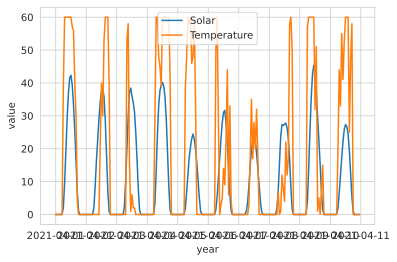

In [30]:

start_day = '2021-04-01' 
end_day = "2021-04-10"
plt.figure()

sns.lineplot(x='Time',y='Solar_minmaxscaled',data=dataset_entsoe[start_day:end_day], label = "Solar")
sns.lineplot(x='Time',y='tsun_muc',data=data_weather_munich[start_day:end_day], label = "Temperature")

plt.xlabel('year',fontsize=10)
plt.ylabel('value',fontsize=10)
plt.show()

We do the same for the wind energy genereation with the weather data of hamburg.
A strong correlation can be seen between the wind energy genereation onshore and the wind speed.

In [31]:
scaler = MinMaxScaler(feature_range=(0,60))
dataset_entsoe["Wind Offshore_minmaxscaled"] = scaler.fit_transform(dataset_entsoe["Wind Offshore"].values.reshape(-1, 1))
dataset_entsoe["Wind Onshore_minmaxscaled"] = scaler.fit_transform(dataset_entsoe["Wind Onshore"].values.reshape(-1, 1))

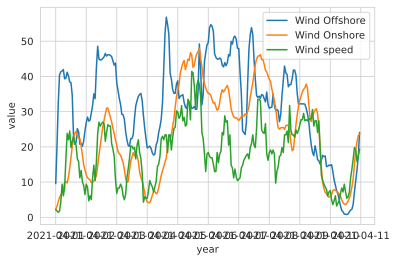

In [32]:
start_day = '2021-04-01' 
end_day = "2021-04-10"
plt.figure()

sns.lineplot(x='Time',y='Wind Offshore_minmaxscaled',data=dataset_entsoe[start_day:end_day], label = "Wind Offshore")
sns.lineplot(x='Time',y='Wind Onshore_minmaxscaled',data=dataset_entsoe[start_day:end_day], label = "Wind Onshore")
sns.lineplot(x='Time',y='wspd_ham',data=data_weather_hamburg[start_day:end_day], label = "Wind speed")

plt.xlabel('year',fontsize=10)
plt.ylabel('value',fontsize=10)
plt.show()